In [1]:
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import cv2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


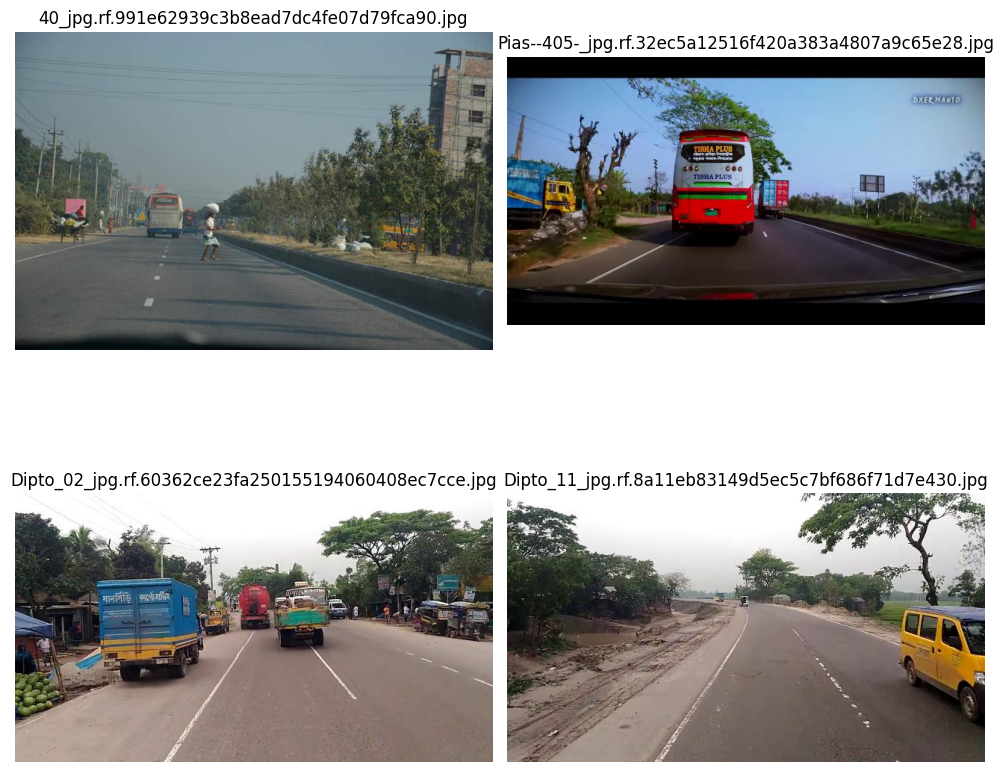

In [10]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Step 2: Define the path to the folder containing images
folder_path = '/content/drive/MyDrive/CSE495 Project/Template_images'  # Change this to your folder's path

# Step 3: List all files in the folder
files = os.listdir(folder_path)

# Filter out non-image files (optional)
image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

# Step 4: Randomly select 4 image files
random_images = random.sample(image_files, 4)

# Step 5: Display the images
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for ax, image_file in zip(axes.ravel(), random_images):
    img = mpimg.imread(os.path.join(folder_path, image_file))
    ax.imshow(img)
    ax.set_title(image_file)
    ax.axis('off')  # Hide axis

plt.tight_layout()
plt.show()

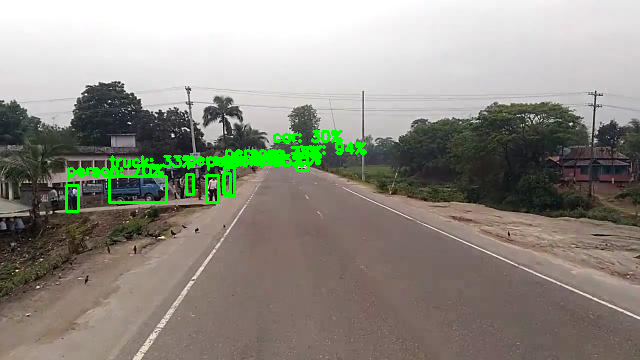

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

# Load YOLO model
net = cv2.dnn.readNet("/content/yolov3.weights", "/content/yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Load COCO class labels
with open("/content/coco.names", "r") as f:
    classes = f.read().splitlines()

# Load image
image = cv2.imread("/content/drive/MyDrive/CSE495 Project/Template_images/Dipto_03_jpg.rf.ebfc7a51d3572e9bdd1a8af1614b4102.jpg")
height, width, _ = image.shape

# Preprocessing: Resize image and normalize it
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)

# Forward pass through YOLO
outputs = net.forward(output_layers)

# Parse outputs
boxes, confidences, class_ids = [], [], []
for output in outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.3:  # Lowered the confidence threshold for testing
            center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype(int)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, int(w), int(h)])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Non-Maximum Suppression to remove overlapping boxes
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)  # Lowered confidence for NMS

# Define the lane region (the area of interest for detection)
lane_region = (int(0.1 * width), int(0.9 * width), int(0.4 * height), int(0.9 * height))

# Draw detected boxes
if len(indices) > 0:
    for i in indices.flatten():  # Ensure we correctly handle the indices
        box = boxes[i]
        x, y, w, h = box
        class_name = classes[class_ids[i]]

        # Check if object is in the highway lane region
        if lane_region[0] < x + w / 2 < lane_region[1] and lane_region[2] < y + h / 2 < lane_region[3]:
            label = f"{class_name}: {int(confidences[i] * 100)}%"
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the result
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = cv2.imread("/content/drive/MyDrive/CSE495 Project/Template_images/Dipto_16_jpg.rf.d762da37ac03337b07cf12bc3631238c.jpg")

# Step 1: Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Preprocess the image using different techniques

# Gaussian Blur
gaussian_blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Median Blur
median_blur = cv2.medianBlur(gray, 5)

# Bilateral Filtering
bilateral_blur = cv2.bilateralFilter(gray, 9, 75, 75)

# CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_image = clahe.apply(gray)

# Step 3: Perform Sobel Edge Detection (both x and y gradients)
sobel_x = cv2.Sobel(gaussian_blur, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gaussian_blur, cv2.CV_64F, 0, 1, ksize=3)
sobel_edge = cv2.magnitude(sobel_x, sobel_y)  # Combine both gradients

# Step 4: Perform Morphological Edge Detection
# First apply dilation followed by erosion (to enhance edges)
kernel = np.ones((5, 5), np.uint8)  # Create a kernel for morphological operation
dilated = cv2.dilate(gaussian_blur, kernel, iterations=1)
eroded = cv2.erode(dilated, kernel, iterations=1)
morphological_edge = cv2.subtract(dilated, eroded)  # Edge as difference between dilated and eroded image

# Step 5: Perform Canny Edge Detection on the preprocessed images
edges_gaussian = cv2.Canny(gaussian_blur, 50, 150)
edges_median = cv2.Canny(median_blur, 50, 150)
edges_bilateral = cv2.Canny(bilateral_blur, 50, 150)
edges_clahe = cv2.Canny(clahe_image, 50, 150)

# Step 6: Dilation of edges to avoid mask boundary detection for each set of edges
kernel = np.ones((5, 5), np.uint8)  # Create a dilation kernel
edges_gaussian_dilated = cv2.dilate(edges_gaussian, kernel, iterations=1)
edges_median_dilated = cv2.dilate(edges_median, kernel, iterations=1)
edges_bilateral_dilated = cv2.dilate(edges_bilateral, kernel, iterations=1)
edges_clahe_dilated = cv2.dilate(edges_clahe, kernel, iterations=1)

# Step 7: Detect Hough Lines on each set of edges
lines_gaussian = cv2.HoughLinesP(edges_gaussian_dilated, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)
lines_median = cv2.HoughLinesP(edges_median_dilated, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)
lines_bilateral = cv2.HoughLinesP(edges_bilateral_dilated, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)
lines_clahe = cv2.HoughLinesP(edges_clahe_dilated, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)

# Step 8: Convert Sobel and Morphological results to uint8
edges_sobel = np.uint8(sobel_edge)  # Convert Sobel result to uint8 format
edges_morphological = np.uint8(morphological_edge)  # Convert Morphological result to uint8 format

# Step 9: Draw lines on the image for each transformation (if lines are detected)
image_gaussian = image.copy()
image_median = image.copy()
image_bilateral = image.copy()
image_clahe = image.copy()

# Draw lines on the image for Gaussian Blur edges
if lines_gaussian is not None:
    for line in lines_gaussian:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_gaussian, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Draw lines on the image for Median Blur edges
if lines_median is not None:
    for line in lines_median:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_median, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Draw lines on the image for Bilateral Blur edges
if lines_bilateral is not None:
    for line in lines_bilateral:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_bilateral, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Draw lines on the image for CLAHE edges
if lines_clahe is not None:
    for line in lines_clahe:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_clahe, (x1, y1), (x2, y2), (0, 255, 255), 2)

# Step 10: Convert images to uint8 format for proper display
images = [
    gaussian_blur, median_blur, bilateral_blur, clahe_image,
    edges_sobel, edges_morphological, edges_gaussian_dilated, edges_median_dilated, edges_bilateral_dilated, edges_clahe_dilated,
    image_gaussian, image_median, image_bilateral, image_clahe
]

# Step 11: Titles for the images
titles = [
    'Gaussian Blur', 'Median Blur', 'Bilateral Blur', 'CLAHE',
    'Sobel Edges', 'Morphological Edges',
    'Canny Edges (Gaussian)', 'Canny Edges (Median)', 'Canny Edges (Bilateral)', 'Canny Edges (CLAHE)',
    'Hough Lines (Gaussian)', 'Hough Lines (Median)', 'Hough Lines (Bilateral)', 'Hough Lines (CLAHE)'
]

# Step 12: Display results in a 2-column grid
fig, axes = plt.subplots(7, 2, figsize=(15, 35))  # Create a 7x2 grid (7 rows, 2 columns)
axes = axes.ravel()  # Flatten the axes array to easily iterate through

# Loop through each image and title to display them in the grid
for i in range(len(images)):
    axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    axes[i].set_title(titles[i], fontsize=12)
    axes[i].axis('off')  # Hide the axes

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

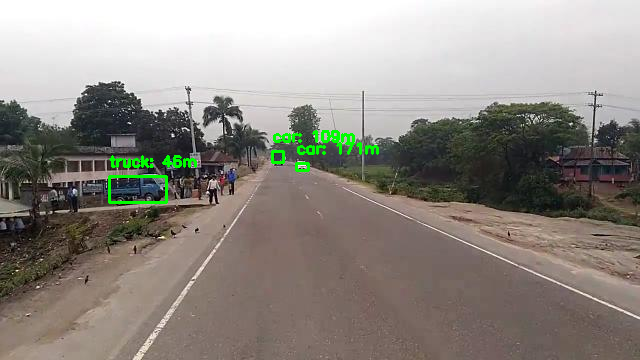

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

# Load YOLO model
net = cv2.dnn.readNet("/content/yolov3.weights", "/content/yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Load COCO class labels
with open("/content/coco.names", "r") as f:
    classes = f.read().splitlines()

# Load image
image = cv2.imread("/content/drive/MyDrive/CSE495 Project/Template_images/Dipto_03_jpg.rf.ebfc7a51d3572e9bdd1a8af1614b4102.jpg")
height, width, _ = image.shape

# Preprocessing: Resize image and normalize it
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)

# Forward pass through YOLO
outputs = net.forward(output_layers)

# Parse outputs
boxes, confidences, class_ids = [], [], []
for output in outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.3:  # Lowered the confidence threshold for testing
            center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype(int)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, int(w), int(h)])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Non-Maximum Suppression to remove overlapping boxes
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)  # Lowered confidence for NMS

# Define the lane region (the area of interest for detection)
lane_region = (int(0.1 * width), int(0.9 * width), int(0.4 * height), int(0.9 * height))

# Define camera parameters for distance calculation (assuming a known object height and focal length)
KNOWN_OBJECT_HEIGHT = 1.5  # meters (height of a car for example)
FOCAL_LENGTH = 800  # Example focal length, may need to be adjusted

# Function to calculate distance based on bounding box height
def calculate_distance(bbox_height):
    # Simple inverse proportionality to estimate distance based on height in the image
    distance = (KNOWN_OBJECT_HEIGHT * FOCAL_LENGTH) / bbox_height
    return distance

# Draw detected boxes
if len(indices) > 0:
    for i in indices.flatten():  # Ensure we correctly handle the indices
        box = boxes[i]
        x, y, w, h = box
        class_name = classes[class_ids[i]]

        # Calculate the distance (based on bounding box height)
        distance = calculate_distance(h)

        # Check if object is in the highway lane region (center of the image)
        if lane_region[0] < x + w / 2 < lane_region[1] and lane_region[2] < y + h / 2 < lane_region[3]:
            # Skip pedestrians or objects not in the center (sidewalks)
            if class_name == "person":
                continue

            # Label the object with class name and calculated distance
            label = f"{class_name}: {int(distance)}m"
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the result
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

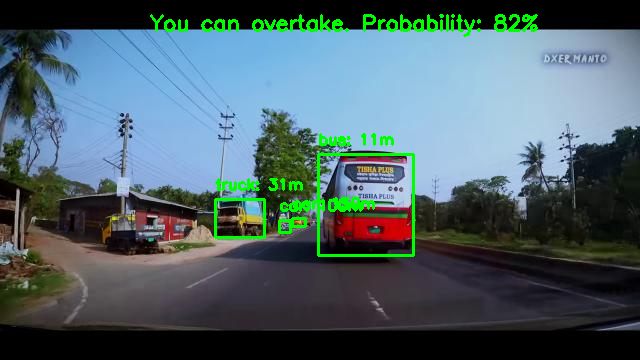

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

# Load YOLO model
net = cv2.dnn.readNet("/content/yolov3.weights", "/content/yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Load COCO class labels
with open("/content/coco.names", "r") as f:
    classes = f.read().splitlines()

# Load image
image = cv2.imread("/content/drive/MyDrive/CSE495 Project/Template_images/Pias--420-_jpg.rf.8ff64897500932be2cd9fb889596a625.jpg")
height, width, _ = image.shape

# Preprocessing: Resize image and normalize it
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)

# Forward pass through YOLO
outputs = net.forward(output_layers)

# Parse outputs
boxes, confidences, class_ids = [], [], []
for output in outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.3:  # Lowered the confidence threshold for testing
            center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype(int)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, int(w), int(h)])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Non-Maximum Suppression to remove overlapping boxes
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)  # Lowered confidence for NMS

# Define the lane region (the area of interest for detection)
lane_region = (int(0.1 * width), int(0.9 * width), int(0.4 * height), int(0.9 * height))

# Define camera parameters for distance calculation (assuming a known object height and focal length)
KNOWN_OBJECT_HEIGHT = 1.5  # meters (height of a car for example)
FOCAL_LENGTH = 800  # Example focal length, may need to be adjusted

# Function to calculate distance based on bounding box height
def calculate_distance(bbox_height):
    # Simple inverse proportionality to estimate distance based on height in the image
    distance = (KNOWN_OBJECT_HEIGHT * FOCAL_LENGTH) / bbox_height
    return distance

# Function to calculate the overtaking probability based on distance
def calculate_overtaking_probability(distance):
    if distance < 2:
        return 15  # Very unsafe, close to the vehicle
    elif distance >= 2 and distance < 10:
        # Linear transition from 15% to 80% as the distance increases from 2 to 10 meters
        return np.clip(((distance - 2) / 8) * 65 + 15, 15, 80)
    elif distance >= 10 and distance < 25:
        # Linear transition from 80% to 100% as the distance increases from 10 to 25 meters
        return np.clip(((distance - 10) / 15) * 20 + 80, 80, 100)
    else:
        return 100  # Safe overtaking above 25 meters

# Find the closest object (box with minimum distance)
closest_distance = float('inf')
closest_box = None
for i in indices.flatten():  # Ensure we correctly handle the indices
    box = boxes[i]
    x, y, w, h = box
    class_name = classes[class_ids[i]]

    # Calculate the distance (based on bounding box height)
    distance = calculate_distance(h)

    # Only consider objects in the lane region
    if lane_region[0] < x + w / 2 < lane_region[1] and lane_region[2] < y + h / 2 < lane_region[3]:
        # Skip pedestrians or objects not in the center (sidewalks)
        if class_name == "person":
            continue

        # Draw all the boxes (even if they are not the closest)
        label = f"{class_name}: {int(distance)}m"
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Check if this object is the closest one
        if distance < closest_distance:
            closest_distance = distance
            closest_box = box

# If a closest object was found, calculate overtaking probability
if closest_box is not None:
    # Calculate overtaking probability for the closest object
    probability = calculate_overtaking_probability(closest_distance)

    # If the probability is greater than 80%, show "You can overtake", otherwise "You cannot overtake"
    overtaking_message = f"You can overtake. Probability: {int(probability)}%" if probability > 80 else f"You cannot overtake. Probability: {int(probability)}%"
else:
    # If no objects are detected in the lane region, it's safe to overtake
    overtaking_message = "You can overtake. Probability: 100%"

# Display the overtaking message at the top-center of the image
cv2.putText(image, overtaking_message, (width // 2 - len(overtaking_message) * 5, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# Display the result
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

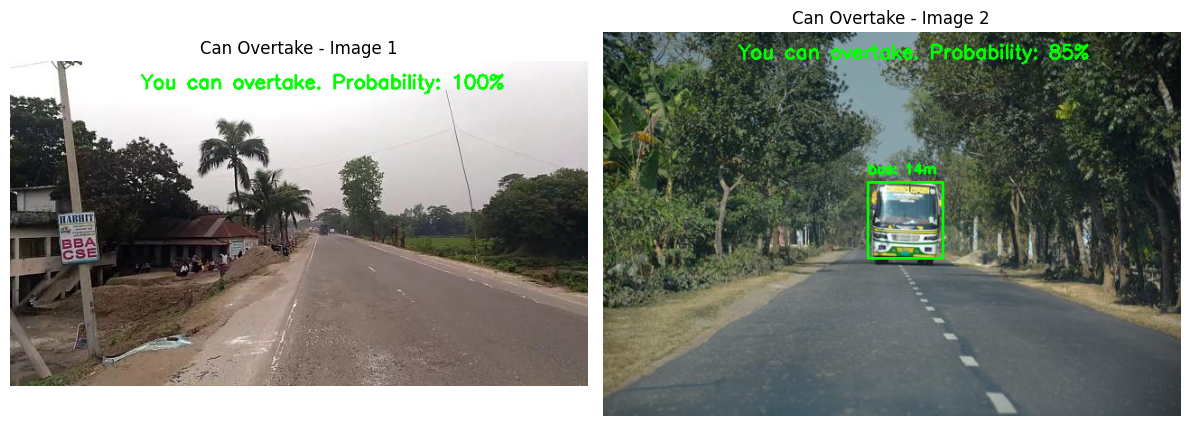

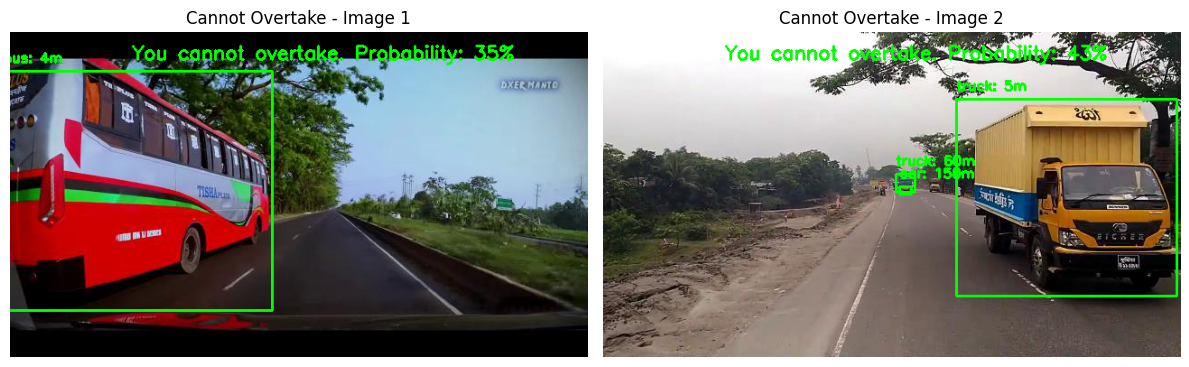

In [4]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# Paths to result images
can_overtake_images = ["/content/Output_Image02.png", "/content/Output_Image07.png"]
cannot_overtake_images = ["/content/Output_Image01.png", "/content/Output_Image05.png"]

# Function to load and display images
def show_images(images, title):
    plt.figure(figsize=(12, 6))
    for i, img_path in enumerate(images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for proper color rendering
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{title} - Image {i + 1}")
    plt.tight_layout()
    plt.show()

# Show "Can Overtake" images
show_images(can_overtake_images, "Can Overtake")

# Show "Cannot Overtake" images
show_images(cannot_overtake_images, "Cannot Overtake")

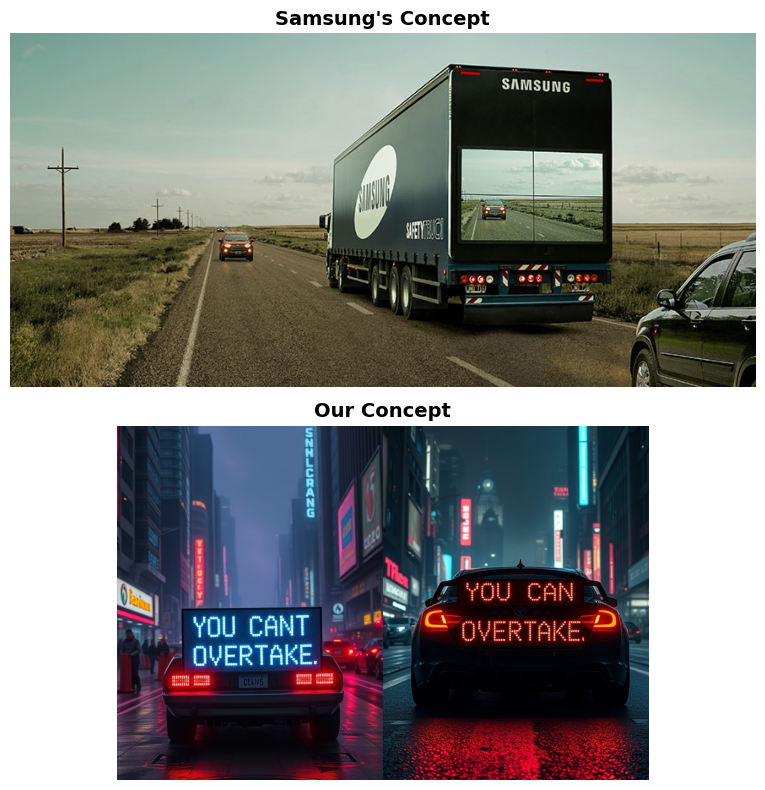

In [16]:
from matplotlib import pyplot as plt
import cv2

# Load images
samsung_image = cv2.imread("/content/Safety_Thumb.jpg")
samsung_image = cv2.cvtColor(samsung_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

our_image1 = cv2.imread("/content/output.jpg")
our_image1 = cv2.cvtColor(our_image1, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

our_image2 = cv2.imread("/content/output2.jpg")
our_image2 = cv2.cvtColor(our_image2, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

# Combine the two "Our Concept" images side by side
combined_our_image = cv2.hconcat([our_image1, our_image2])

# Resize Samsung's concept image during visualization (reduce by a scaling factor)
scaling_factor = 1  # Adjust this value to resize as needed
new_samsung_width = int(samsung_image.shape[1] * scaling_factor)
new_samsung_height = int(samsung_image.shape[0] * scaling_factor)
samsung_resized = cv2.resize(samsung_image, (new_samsung_width, new_samsung_height))

# Create a figure
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 1]})

# Display Samsung's concept (resized)
axs[0].imshow(samsung_resized)
axs[0].axis('off')
axs[0].set_title("Samsung's Concept", fontsize=14, weight='bold')

# Display Our concept images side by side
axs[1].imshow(combined_our_image)
axs[1].axis('off')
axs[1].set_title("Our Concept", fontsize=14, weight='bold')

# Tighten layout
plt.tight_layout()
plt.show()